In [110]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 293.3/293.3 kB 1.4 MB/s eta 0:00:00


In [2]:
# все библиотеки использованные в проекте
from math import fabs
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# обучающие данные
df_x = pd.read_csv('data/X_train.csv')
label_y = pd.read_csv('data/y_train.csv')

In [86]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199861 entries, 0 to 1199860
Data columns (total 49 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1199861 non-null  int64  
 1   acc_now_delinq              1199861 non-null  float64
 2   addr_state                  1199861 non-null  object 
 3   annual_inc                  1199861 non-null  float64
 4   chargeoff_within_12_mths    1199824 non-null  float64
 5   collections_12_mths_ex_med  1199824 non-null  float64
 6   delinq_2yrs                 1199861 non-null  float64
 7   dti                         1199861 non-null  float64
 8   earliest_cr_line            1199861 non-null  object 
 9   emp_length                  1128114 non-null  float64
 10  fico_range_high             1199861 non-null  float64
 11  fico_range_low              1199861 non-null  float64
 12  funded_amnt                 1199861 non-null  float64
 1

In [103]:
df_x.head()

,index,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,...,tax_liens,term,title,total_acc,verification_status,zip_code,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year
0,0,0.0,1,80000.0,0.0,0.0,0.0,30.49,Oct-1996,4.0,...,0.0,36,1483.0,26.0,1,1.0,1,2016,1,2016
1,1,0.0,2,82000.0,0.0,0.0,0.0,7.00,Mar-1993,10.0,...,0.0,36,1483.0,11.0,2,2.0,2,2017,2,2017
2,2,0.0,3,46080.0,0.0,0.0,1.0,17.32,Nov-2000,3.0,...,0.0,36,1483.0,31.0,1,3.0,3,2016,3,2016
3,3,0.0,4,30000.0,0.0,0.0,0.0,7.80,Jan-2010,0.0,...,0.0,36,2.0,24.0,1,4.0,3,2015,3,2015
4,4,0.0,5,70000.0,0.0,0.0,0.0,13.36,Jan-2002,0.0,...,0.0,60,3.0,16.0,2,5.0,2,2017,2,2017


## Приведение даненых к нормальному виду

### 1 - избавление от лишних столбйцов
zip_code - возможно имеет зависимость географическое положение (пока не дропаем)(кодируем)




### Функции преобразования данных

In [4]:
# функция создания глобальных файлов
def create_global_file(df, name_column, name_txt):
    dict_df = {}
    j = 1
    for i in df[name_column].unique().tolist():
        if pd.isna(i):
            pass
        else:
            dict_df[i] = j
            j += 1
    with open(f'global_files/{name_txt}.txt', 'w', encoding='utf-8') as f:
        for x, y in dict_df.items():
            f.write(f'{x} {y}\n')


def load_global_file(file_name, type=1):
    with open(f'{file_name}', 'r', encoding='utf-8') as f:
        res = {}
        for i in f.readlines():
            if type == 1:
                key, value = i.split()
            else:
                s_split = i.split()
                key, value = (''.join(s_split[:-1:])), s_split[-1]

            res[key] = int(value)

    return res


In [5]:
# функции преобразования данных
def convert_verification_status_to_int(x):
    if x == 'Source Verified':
        return 1
    elif x == 'Not Verified':
        return 2
    else:
        return 3
def convert_workyear(x):
    s = ''.join(x.split())
    if s[2] == '+':
        return 10
    elif s[0] == '<':
        return 0
    else:
        return int(s[0])


In [ ]:
# создание глобальных файлов, чтобы новый поток данных кадировлся идентично старым
create_global_file(df_x, 'zip_code', 'zip_code')
create_global_file(df_x, 'addr_state', 'addr_state')
create_global_file(df_x, 'home_ownership', 'home_ownership')
create_global_file(df_x, 'title', 'title')
create_global_file(df_x, 'purpose', 'purpose')
create_global_file(df_x, 'earliest_cr_line_month', 'month')

In [8]:
# пути к глобальным файлам в которых кодируются строки
ZIP_CODE_FILE = 'global_files/zip_code.txt'
ADDR_STATE = 'global_files/addr_state.txt'
HOME_OWNERSHIP = 'global_files/home_ownership.txt'
TITLE = 'global_files/title.txt'
PURPOSE_FILE = 'global_files/purpose.txt'
MONTH_FILE = 'global_files/month.txt'

In [6]:
df_x['term'] = df_x['term'].apply(lambda x: x if pd.isna(x) else int(x.split()[0]))
df_x['emp_length'] = df_x['emp_length'].apply(lambda x: x if pd.isna(x) else convert_workyear(x))
df_x['int_rate'] = df_x['int_rate'].apply(lambda x: x if pd.isna(x) else float(x.split('%')[0]))
df_x['revol_util'] = df_x['revol_util'].apply(lambda x: x if pd.isna(x) else float(x.split('%')[0]))
df_x['issue_d_month'] = df_x.issue_d.apply(lambda x: x if pd.isna(x) else x.split('-')[0])
df_x['issue_d_year'] = df_x.issue_d.apply(lambda x: x if pd.isna(x) else int(x.split('-')[1]))
df_x['earliest_cr_line_month'] = df_x.earliest_cr_line.apply(lambda x: x if pd.isna(x) else x.split('-')[0])
df_x['earliest_cr_line_year'] = df_x.earliest_cr_line.apply(lambda x: x if pd.isna(x) else int(x.split('-')[1]))
df_x['verification_status'] = df_x['verification_status'].apply(
    lambda x: x if pd.isna(x) else convert_verification_status_to_int(x))


In [9]:
zip_code_dict = load_global_file(ZIP_CODE_FILE)
df_x['zip_code'] = df_x['zip_code'].apply(lambda x: x if pd.isna(x) else int(zip_code_dict[x]))
addr_state_dict = load_global_file(ADDR_STATE)
df_x['addr_state'] = df_x['addr_state'].apply(lambda x: x if pd.isna(x) else int(addr_state_dict[x]))
home_ownership_dict = load_global_file(HOME_OWNERSHIP)
df_x['home_ownership'] = df_x['home_ownership'].apply(lambda x: x if pd.isna(x) else int(home_ownership_dict[x]))
title_dict = load_global_file(TITLE, 'title')
df_x['title'] = df_x['title'].apply(lambda x: x if pd.isna(x) else int(title_dict[''.join(x.split())]))
purpose_dict = load_global_file(PURPOSE_FILE)
df_x['purpose'] = df_x['purpose'].apply(lambda x: x if pd.isna(x) else int(purpose_dict[x]))
month_dict = load_global_file(MONTH_FILE)
df_x['earliest_cr_line_month'] = df_x['earliest_cr_line_month'].apply(lambda x: x if pd.isna(x) else int(month_dict[x]))
df_x['issue_d_month'] = df_x['issue_d_month'].apply(lambda x: x if pd.isna(x) else int(month_dict[x]))

In [10]:
# удаление луже не нужных столбцов
df_x.drop(['issue_d','earliest_cr_line'],axis=1,inplace=True)

In [11]:
# нормализация столбцов
base_columns = ('index','addr_state','emp_lenght','home_ownership','term','title','verification_status','zip_code','earliest_cr_line_month','issue_d_month','earliest_cr_line_year','issue_d_year')
for i in df_x.columns:
    if i not in base_columns:
        df_x[i] = (df_x[i] - df_x[i].mean() )/ df_x[i].var()

# Проверим матрицу корреляций
признаки корреляция между которыми больше 85 % по модулю будут удаляться

<Axes: >

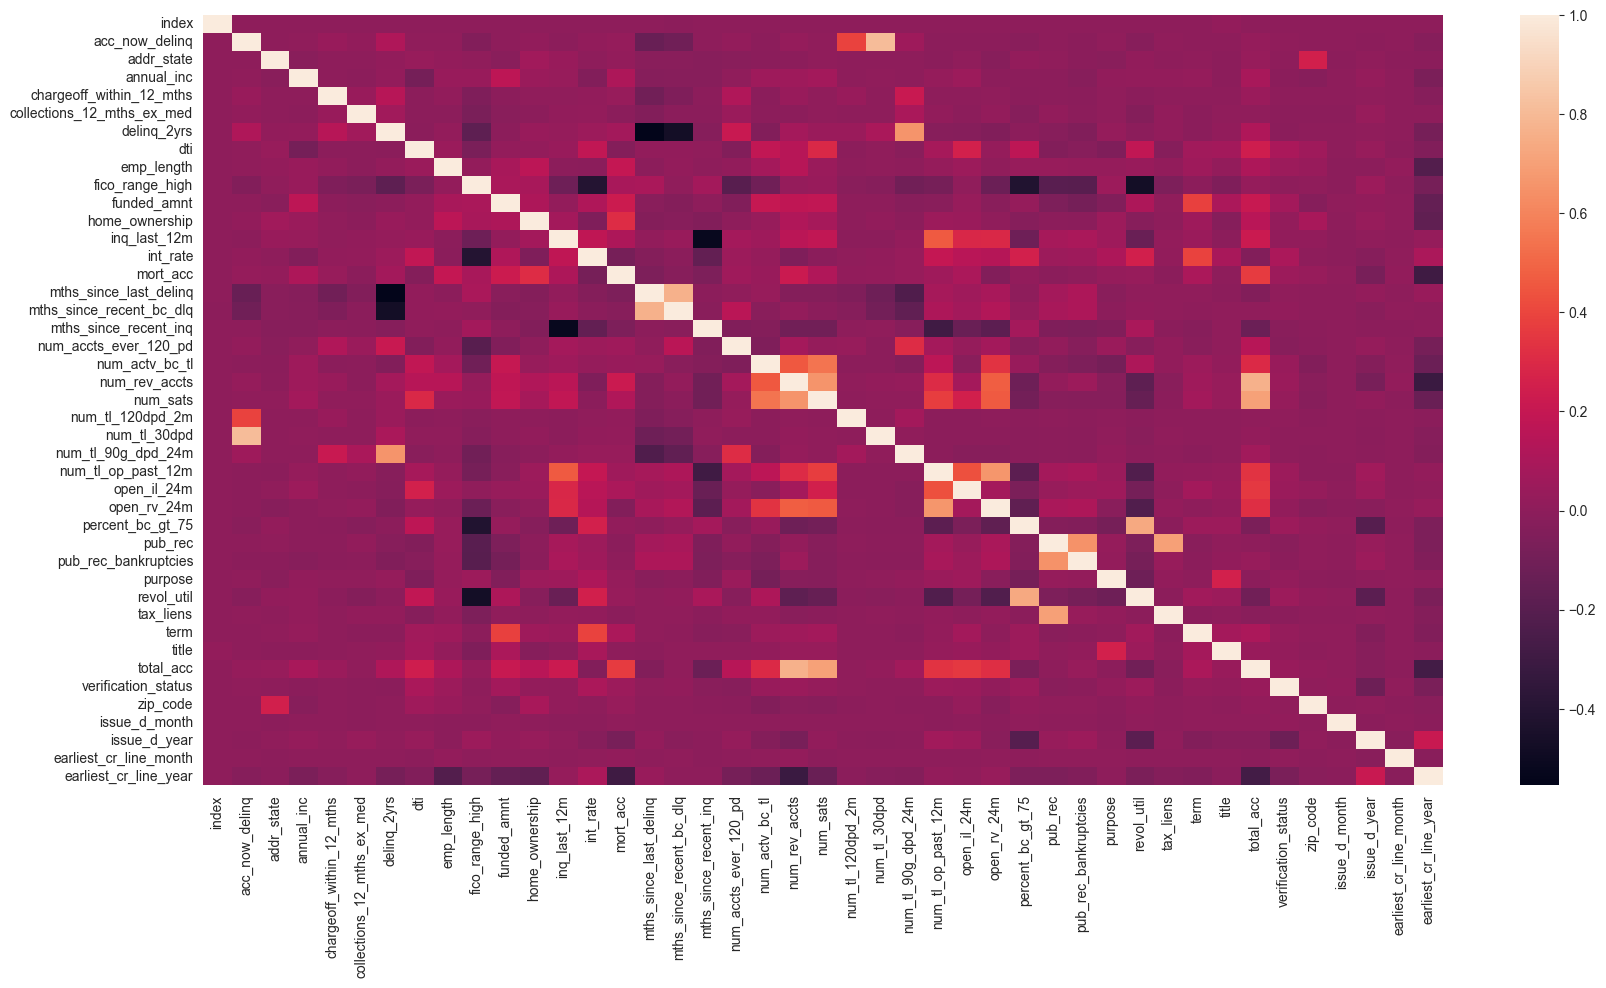

In [16]:
plt.figure(figsize = (20,10))
sns.heatmap(df_x.corr())

In [17]:
df_x.corr()

,index,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,fico_range_high,...,tax_liens,term,title,total_acc,verification_status,zip_code,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year
index,1.000000,0.000937,-0.000307,0.000753,-0.000880,0.000417,0.002134,-0.000775,0.000810,-0.001722,...,0.001093,-0.001116,0.021250,0.000078,0.000702,0.000102,0.000458,0.000350,-0.001076,0.001423
acc_now_delinq,0.000937,1.000000,0.002297,0.005950,0.035715,0.013021,0.118874,0.004890,0.008816,-0.039446,...,0.007829,0.000480,0.002750,0.025790,0.007573,0.000340,0.000210,-0.005325,0.000908,-0.029016
addr_state,-0.000307,0.002297,1.000000,-0.015461,-0.001526,-0.001277,0.012452,0.029895,0.018518,0.009404,...,0.004166,0.009818,-0.007274,0.032535,0.002155,0.250785,-0.002444,0.009935,-0.006116,-0.008935
annual_inc,0.000753,0.005950,-0.015461,1.000000,0.003787,-0.003220,0.020794,-0.089276,0.034982,0.036357,...,0.019584,0.028500,-0.005998,0.092520,-0.012886,-0.024404,0.000735,0.028026,0.000839,-0.066960
chargeoff_within_12_mths,-0.000880,0.035715,-0.001526,0.003787,1.000000,0.039861,0.144410,-0.002343,0.010518,-0.053685,...,-0.000927,-0.000773,0.003561,0.041557,0.003803,-0.001336,0.001120,0.007565,0.000902,-0.029945
collections_12_mths_ex_med,0.000417,0.013021,-0.001277,-0.003220,0.039861,1.000000,0.068307,-0.004601,-0.007830,-0.071823,...,0.012032,-0.009106,0.005238,0.004388,-0.006638,-0.004293,-0.001926,0.031113,-0.001093,0.001715
delinq_2yrs,0.002134,0.118874,0.012452,0.020794,0.144410,0.068307,1.000000,-0.012259,0.021130,-0.176767,...,0.011012,-0.008346,0.011378,0.117736,-0.010049,-0.000147,0.000690,0.005533,-0.000363,-0.081980
dti,-0.000775,0.004890,0.029895,-0.089276,-0.002343,-0.004601,-0.012259,1.000000,0.046593,-0.072275,...,-0.029085,0.065940,0.075486,0.238391,0.100889,0.063701,0.003431,0.031057,-0.005292,-0.049260
emp_length,0.000810,0.008816,0.018518,0.034982,0.010518,-0.007830,0.021130,0.046593,1.000000,0.022011,...,0.014920,0.057799,0.022186,0.108457,0.051247,0.037926,-0.002266,-0.003873,0.018889,-0.215669
fico_range_high,-0.001722,-0.039446,0.009404,0.036357,-0.053685,-0.071823,-0.176767,-0.072275,0.022011,1.000000,...,-0.059441,-0.003947,-0.055353,0.025295,0.002616,0.005783,-0.007119,0.052789,-0.000609,-0.083255


In [15]:
# высокая корреляция имеется между
corr = df_x.corr().to_dict()
hight_corr = {}
for column_a in corr:
    for column_b in corr[column_a]:
        if fabs(corr[column_a][column_b]) >= 0.85 and column_a != column_b:
            if column_b in hight_corr:
                if column_a not in hight_corr[column_b]:
                    if column_a in hight_corr:
                        hight_corr[column_a].append(column_b)
                    else:
                        hight_corr[column_a] = [column_b]

            else:
                if column_a in hight_corr:
                    hight_corr[column_a].append(column_b)
                else:
                    hight_corr[column_a] = [column_b]

del_col = []
for i in hight_corr:
    del_col.extend(hight_corr[i])
df_x.drop(set(del_col),axis=1,inplace=True)

In [14]:
hight_corr

{'fico_range_high': ['fico_range_low'],
 'funded_amnt': ['installment', 'loan_amnt'],
 'installment': ['loan_amnt'],
 'num_sats': ['open_acc']}